In [16]:
from spaed import spaed
import pandas as pd
import matplotlib.pyplot as plt

import json
import itertools
import numpy as np
from spaed import spaed_, load_pae, get_delineations
from sklearn.metrics import precision_score, recall_score, f1_score

# General functions

In [17]:
def load_predictions(filename):
    df = pd.read_csv(filename, index_col= 0)
    df.index = df.index.astype(str)
    df.linkers = df.linkers.astype(str)
    df.disordered = df.disordered.astype(str)
    df.domains = df.domains.astype(str)
    return df

In [18]:
def load_gt(filename):
    gt = pd.read_excel(filename, index_col=0)
    gt = gt.loc[~gt.proteinID.isin(["PlyCHPC925", "A0A126GGK7", "Q7Y3F3", "Q2I7P1", "A0A4D6AQP8"])]
    gt.proteinID = gt.proteinID.astype(str)

    gt.linkers = gt.linkers.astype(str)
    gt.disordered = gt.disordered.astype(str)
    gt.domains = gt.domains.astype(str)

    gt.index = gt.proteinID
    gt.index.name = None
    return gt

In [19]:
def compare_delineations(hier, gt, chainsaw):
    
    cmap, norm = create_cmap()

    comp = pd.DataFrame([hier, gt, chainsaw])
    
    fig, ax = plt.subplots(figsize=(20, 1))
    ax.imshow(comp, aspect="auto", cmap=cmap, norm=norm)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(["spaed","gt", "chainsaw"])

    plt.show()

In [20]:
def format_chainsaw_linkers(linkers):
    if (linkers == "nan") | (linkers == None) | (linkers == ""): return "nan"
    else:
        linkers_tr=""
        for i in linkers.split(";"):
            start = int(i.split("-")[0])+1
            end = int(i.split("-")[1])-1
            linkers_tr = linkers_tr + ";" + str(start) + "-" + str(end)
        return linkers_tr.lstrip(";")

def load_chainsaw(filepath):
    chainsaw = pd.read_csv(filepath, sep="\t")

    chainsaw.chain_id = chainsaw.chain_id.str.replace("unrelaxed_rank_001_alphafold2_ptm_model", "").str.replace("_seed_000", "").str.rpartition("_")[0].str.rstrip("_")
    chainsaw.index = chainsaw.chain_id
    chainsaw.index.name = None
    chainsaw = chainsaw.drop(columns="chain_id")
    #chainsaw = chainsaw.loc[~chainsaw.index.isna()]
    chainsaw = chainsaw.loc[~chainsaw.index.isin(["PlyCHPC925", "A0A126GGK7", "Q7Y3F3", "Q2I7P1", "A0A4D6AQP8"])]

    chainsaw.nres = chainsaw.nres.astype(int).astype(str)
    chainsaw = chainsaw.loc[~chainsaw.nres.isna()]
    chainsaw["domains"] = chainsaw.chopping.str.replace(",", ";")

    chainsaw["disordered_start"] = "1-"+ (chainsaw.chopping.str.split("-").str[0].astype(int)-1).astype(str)
    chainsaw.loc[chainsaw.disordered_start=="1-0", "disordered_start"] = ""
    chainsaw["disordered_end"] = (chainsaw.chopping.str.split("-").str[-1].astype(int)+1).astype(str) + "-" + chainsaw.nres
    chainsaw.loc[chainsaw.disordered_end==(chainsaw.nres.astype(int)+1).astype(str) + "-" + chainsaw.nres, "disordered_end"] = ""

    chainsaw["disordered"] = chainsaw["disordered_start"] + ";" + chainsaw["disordered_end"]
    chainsaw.disordered = chainsaw.disordered.str.lstrip(";").str.rstrip(";")
    chainsaw = chainsaw.drop(columns=["disordered_start", "disordered_end"])

    chainsaw["linkers"] = chainsaw.domains.str.partition("-")[2].str.rpartition("-")[0].str.replace("-", ":").str.replace(";", "-").str.replace(":", ";")
    chainsaw.linkers = chainsaw.linkers.apply(format_chainsaw_linkers)

    chainsaw.nres = chainsaw.nres.astype(int)

    return chainsaw

# Functions for scoring

In [51]:
# param_values is a dict containing values for parameter we are testing : ex. {"PAE_SCORE_CUTOFF": [1, 2, 3, 4, 5]}
# constant_params is a dict containing parameters that stay constant : ex. {"FREQ_LINKER": 25, "RATIO_NUM_CLUSTERS":10}
def make_preds(params, gt):
    preds =  pd.DataFrame(columns=["length", "# domains", "domains", "linkers", "disordered"]).astype(object)
    for lysin in gt.index:
        pae = load_pae(f"../emma/roberto_lysins/{lysin}_predicted_aligned_error_v1.json")
        clusters = spaed_(pae, PAE_SCORE_CUTOFF=params["PAE_SCORE_CUTOFF"], FREQ_LINKER=params["FREQ_LINKER"], 
                                       RATIO_NUM_CLUSTERS=params["RATIO_NUM_CLUSTERS"])

        delin = get_delineations(clusters)
        preds.loc[lysin, ["domains", "linkers", "disordered"]] = delin.loc[0]
        preds.loc[lysin, "length"] = len(pae)

    return preds

def calc_scores(preds, gt):
    pred_scores = []; pred_distances = []
    gt_scores = []; gt_distances = []
    iou_scores = []
    
    for lysin in gt.index:
        pred_score, pred_distance, gt_score, gt_distance = domBoundaryScore(lysin, preds, gt, preds.loc[lysin, "length"])
        pred_scores.append(pred_score); pred_distances.append(pred_distance)
        gt_scores.append(gt_score); gt_distances.append(gt_distance)

        iou_scores.append(calc_iou(lysin, gt, preds))
    
    return pred_scores, pred_distances, gt_scores, gt_distances, iou_scores

def optimize(param_values, constant_params, gt):
    all_pred_scores = {}; all_pred_distances = {}
    all_gt_scores = {}; all_gt_distances = {}
    all_iou_scores = {}

    for param in param_values:
        for i in param_values[param]:
            constant_params[param] = i

            preds = make_preds(constant_params, gt)
            pred_scores, pred_distances, gt_scores, gt_distances, iou_scores = calc_scores(preds, gt)

            all_pred_distances[f"{i}"] = pred_distances; all_pred_scores[f"{i}"] = pred_scores #for precision
            all_gt_distances[f"{i}"] = gt_distances; all_gt_scores[f"{i}"] = gt_scores #for recall
            all_iou_scores[f"{i}"] = iou_scores
    
    return all_pred_scores, all_pred_distances, all_gt_scores, all_gt_distances, all_iou_scores

In [47]:
def plot_score_bars(all_pred_scores, all_gt_scores, all_iou_scores):
    pd.DataFrame(all_pred_scores).plot.box()
    plt.title("Domain Boundary Distance Score")
    plt.show()

    pd.DataFrame(all_gt_scores).plot.box()
    plt.title("Recall DBD Score")
    plt.show()

    pd.DataFrame(all_iou_scores).plot.box()
    plt.title("Intersect over Union Score")
    plt.show()

In [48]:
def scores_per_distance(all_distances, title, filename=""):
    for i in all_distances:
        out = np.concatenate(all_distances[i], axis=None).ravel()
        out = out[out != None]

        distances = [0, 1, 2, 3, 4, 5, 6, 7]
        accs = []
        for j in distances:
            accs.append((out <= j).sum() / len(out))
        plt.plot(distances, accs, label=i)
    plt.title(title)
    plt.xlabel("Distance (# residues between pred-GT)")
    plt.legend()
    plt.ylim(0,1)
    if filename != "":
        plt.savefig(filename)
    plt.show()

### Domain boundary distance score

In [23]:
# get all residues part of linkers as a list
def get_linkers_as_clusters(df, protID):
    linker_bounds = []
    for linker in df.loc[protID, "linkers"].split(";"):
        start = int(linker.split("-")[0])
        end = int(linker.split("-")[1])

        linker_bounds += list(range(start, end+1))
    return linker_bounds


# get residues part of bounds (boundaries + linkers)
def get_dom_bounds(df, protID):
    linker_bounds = get_linkers_as_clusters(df, protID)
    
    bounds = df.loc[protID, "domains"].replace(";", "-").split("-") 
    bounds_wLinkers = np.array(bounds + linker_bounds).astype(int)

    return bounds, bounds_wLinkers

# Calculate boundary score. 
def computeBoundaryScore(df, protID, bounds, bounds_wLinkers, length):
    scores = []
    numBoundsSub = 0
    test_bounds = df.loc[protID, "domains"].replace(";", "-").split("-") #get boundaries we are testing
    for bound in test_bounds:
        #check start boundary
        bound = int(bound)
        if bound == 1: numBoundsSub += 1 #ignore boundary if it is at beginning of sequence
        elif bound == length: numBoundsSub += 1 #ignore boundary if it is at the end of sequence
        else:
            closestB = bounds_wLinkers[np.argmin(abs(bounds_wLinkers - bound))] #find the nearest "real" boundary
            if abs(closestB - bound) < 8: score = 8 - abs(closestB - bound); # calculate score if within 8 residues
            else: score = 0 #score attributed if 8 residues or further
            scores.append(score)
            
    numBounds = max(len(bounds), len(test_bounds)) - numBoundsSub
    return np.sum(scores) / (8*numBounds), 8 - np.array(scores) # Return scores and distances


def domBoundaryScore(protID, preds, gt, length):
    # gt and preds have no linkers
    if (((preds.loc[protID, "linkers"] == "nan") | ((preds.loc[protID, "linkers"] == ""))) & 
    ((gt.loc[protID, "linkers"] == "nan") | ((gt.loc[protID, "linkers"] == "")))): return 1, 0, 1, 0
        
    # gt or pred has no linkers, but not both
    if ((preds.loc[protID, "linkers"] == "nan") | (preds.loc[protID, "linkers"] == "") | 
        (gt.loc[protID, "linkers"] == "nan") | (gt.loc[protID, "linkers"] == "")): return 0, None, 0, None

    
    #PRECISION : Number of correctly predicted domain boundaries
    # get residues part of bounds (boundaries + linkers)
    gt_bounds, gt_bounds_wLinkers = get_dom_bounds(gt, protID)

    # calculate scores based on distances from real boundary (8 points for perfect alignment, -1 for every residu between prediction and gt)
    pred_scores, pred_distances = computeBoundaryScore(preds, protID, gt_bounds, gt_bounds_wLinkers, length)

    
    # RECALL : Number of "real" boundaries (in gt) that got predicted correctly
    # get residues part of predicted bounds (boundaries + linkers)
    pred_bounds, pred_bounds_wLinkers = get_dom_bounds(preds, protID)

    # calculate scores based on distances from real boundary (8 points for perfect alignment, -1 for every residu between prediction and gt)
    gt_scores, gt_distances = computeBoundaryScore(gt, protID, pred_bounds, pred_bounds_wLinkers, length)

    return pred_scores, pred_distances, gt_scores, gt_distances

### IoU scores

In [24]:
def calc_iou_per_domain(pred_dom, gt_dom):
    inter = len(set(pred_dom) & set(gt_dom))
    union = len(set(pred_dom).union(gt_dom))
    return inter / union

def get_domains(delin):
    domains = []
    for i in delin.split(";"):
        if (i == 'nan') | (i == ""): return []

        start = int(i.split("-")[0])
        end = int(i.split("-")[1])

        reg = list(range(start, end+1))
        domains += [reg]
    return domains

def permut(l1, l2):
    unique = []
    if len(l1) >= len(l2):
        permut = itertools.permutations(l1, len(l2))
        for comb in permut:
            zipped = zip(comb, l2)
            unique.append(list(zipped))
    else:
        permut = itertools.permutations(l2, len(l1))
        for comb in permut:
            zipped = zip(l1, comb)
            unique.append(list(zipped))
    
    return unique

def calc_iou(ID, gt, preds):
    gt_delin = gt.loc[ID].domains
    pred_delin = preds.loc[ID].domains
    
    # Calc iou for every pred/gt domain pairs
    GTdoms = get_domains(gt_delin)
    PREDdoms = get_domains(pred_delin)
    scores = pd.DataFrame(index=range(len(PREDdoms)), columns=range(len(GTdoms)))

    for i, GTdom in enumerate(GTdoms):
        for j, PREDdom in enumerate(PREDdoms):
            iou_dom = calc_iou_per_domain(PREDdom, GTdom)
            scores.iloc[j, i] = iou_dom

    #Generate dom and GT combinations
    import itertools
    c = permut(scores.index, scores.columns)

    #Find the best matches between preds and GT, such that GT domains correspond only to one pred domain and vice versa
    saved = [0, 0]
    for i in c:
        sum_iou = 0
        for j in i:
            sum_iou += scores.iloc[j]
        if sum_iou > saved[1]:
            saved = [i, sum_iou]

    #calc final iou score
    len_all_doms = len([x for xs in GTdoms for x in xs])
    final=0

    for i in saved[0]:
        final += scores.iloc[i] * ( len(GTdoms[i[1]]) / len_all_doms )
    return final

### Optimization

In [28]:
gt = load_gt("..\Roberto\lysins\lysins_wDomains.xlsx")
gt_subset = gt.sample(frac=0.75, random_state=1)

**PAE score cutoff**\
A PAE score of 4 or 5 seems to have the best compromise between precision and recall.

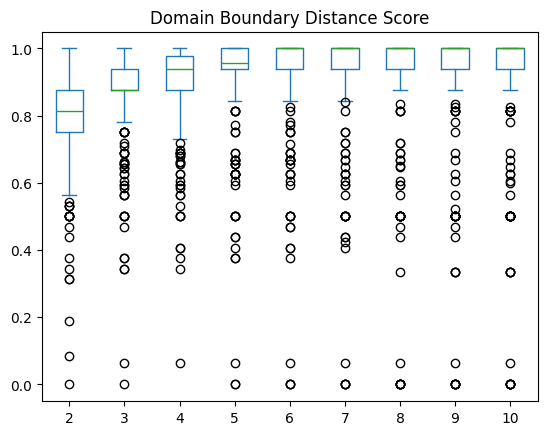

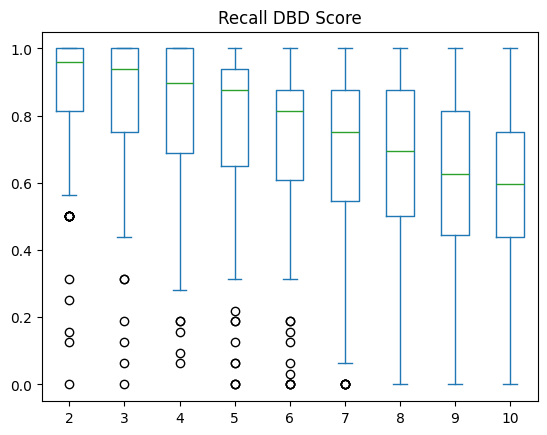

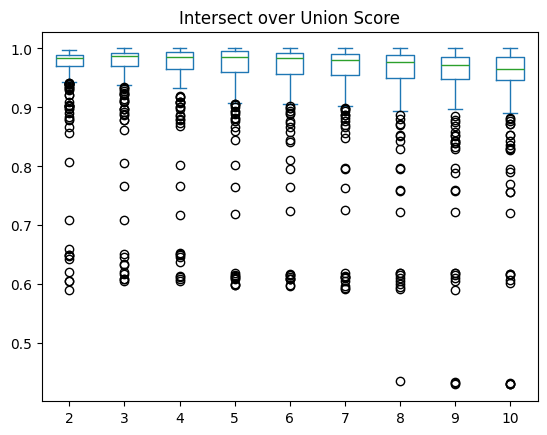

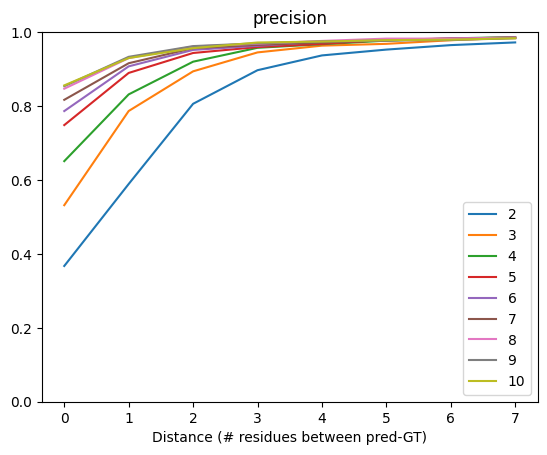

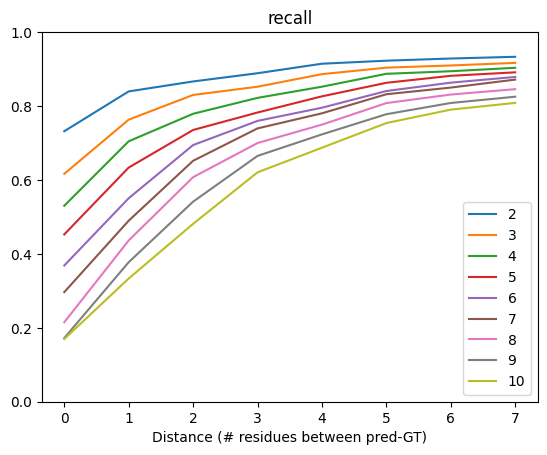

In [66]:
param_values = {"PAE_SCORE_CUTOFF": [2, 3, 4, 5, 6, 7, 8, 9, 10]}
constant_params = {"RATIO_NUM_CLUSTERS": 10, "FREQ_LINKER":6}
aps_pae, apd_pae, ags_pae, agd_pae, ais_pae = optimize(param_values, constant_params, gt_subset)
plot_score_bars(aps_pae, ags_pae, ais_pae)
scores_per_distance(apd_pae, "precision")
scores_per_distance(agd_pae, "recall")

**Ratio number of clusters to the length of protein**\

A ratio of 10 seems best. This means for a protein 400 residues long, a maximum of 40 clusters will be generated.

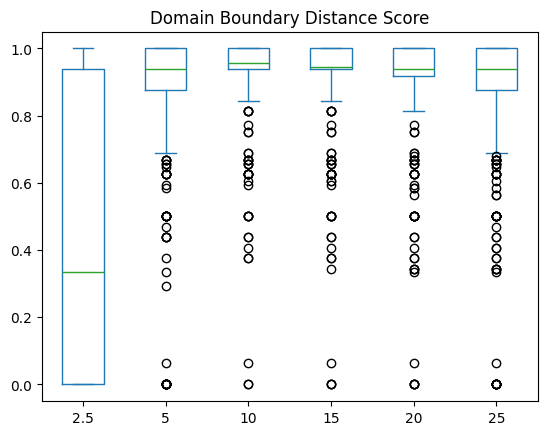

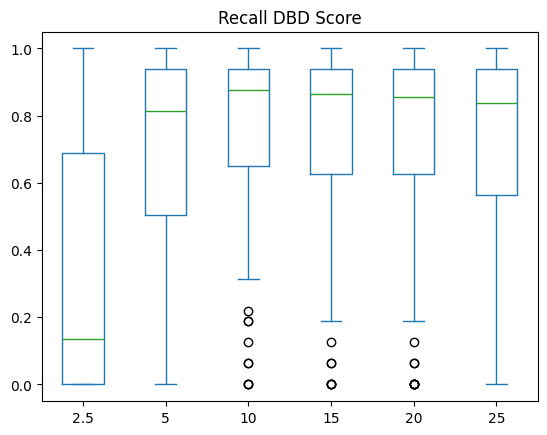

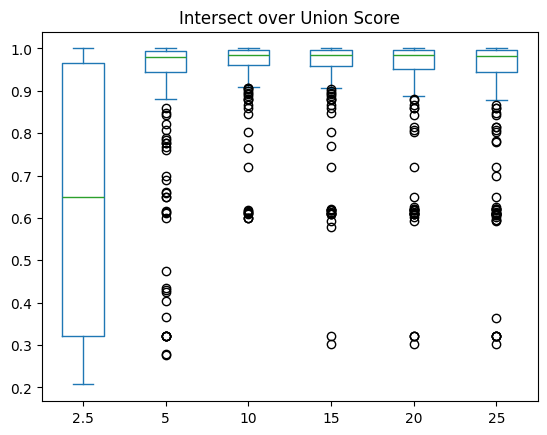

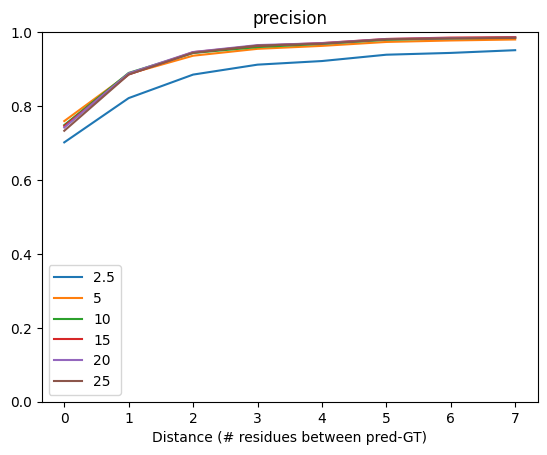

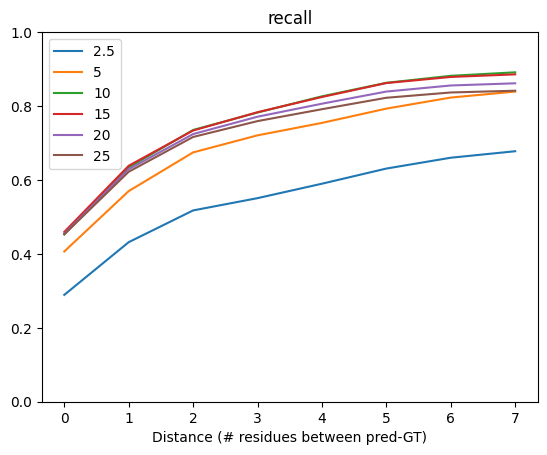

In [69]:
param_values = {"RATIO_NUM_CLUSTERS": [2.5, 5, 10, 15, 20, 25]}
constant_params = {"PAE_SCORE_CUTOFF": 5, "FREQ_LINKER":6}
aps_clust, apd_clust, ags_clust, agd_clust, ais_clust = optimize(param_values, constant_params, gt_subset)
plot_score_bars(aps_clust, ags_clust, ais_clust)
scores_per_distance(apd_clust, "precision")
scores_per_distance(agd_clust, "recall")

**Linker frequency**\
A frequency of 6 seems best overall, but if we want to obtain longer linkers, we can increase this value.

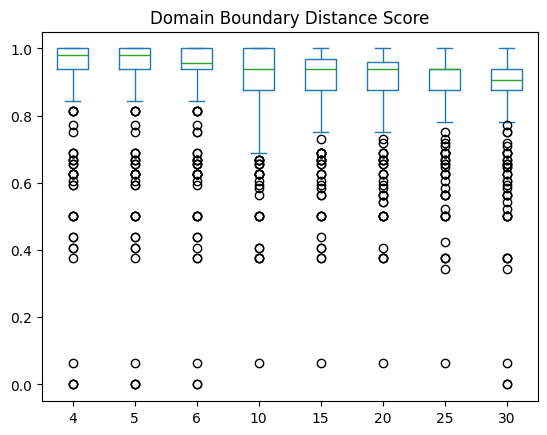

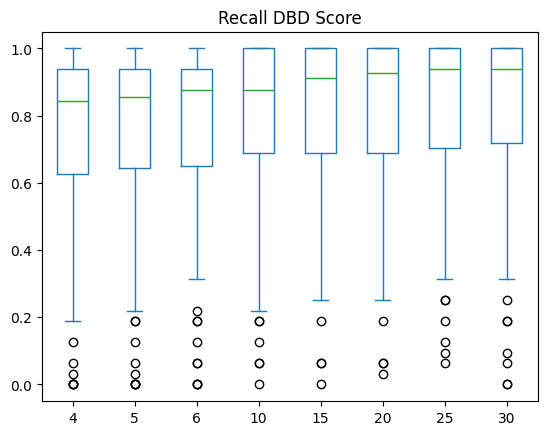

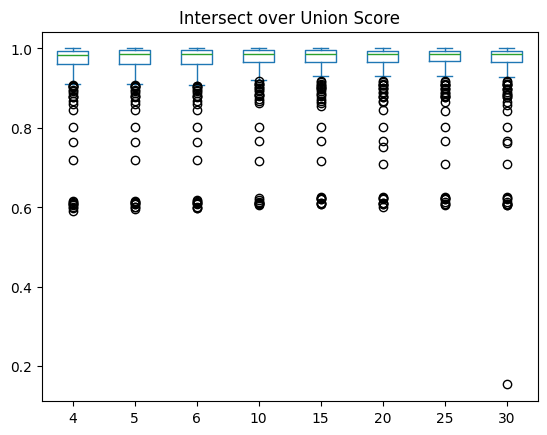

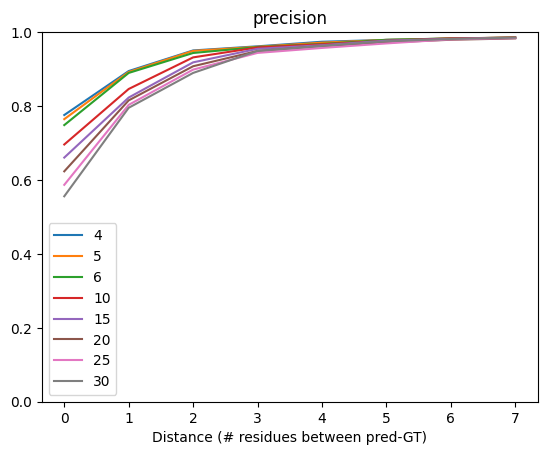

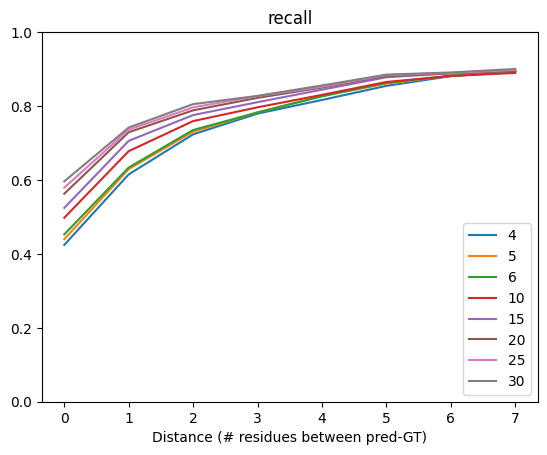

In [68]:
param_values = {"FREQ_LINKER": [4, 5, 6, 10, 15, 20, 25, 30]}
constant_params = {"RATIO_NUM_CLUSTERS": 10, "PAE_SCORE_CUTOFF":5}
aps_link, apd_link, ags_link, agd_link, ais_link = optimize(param_values, constant_params, gt_subset)
plot_score_bars(aps_link, ags_link, ais_link)
scores_per_distance(apd_link, "precision")
scores_per_distance(agd_link, "recall")

Final test on ~80 lysins not included in the optmization:

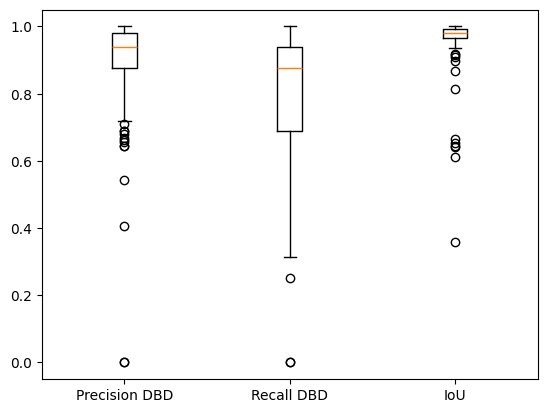

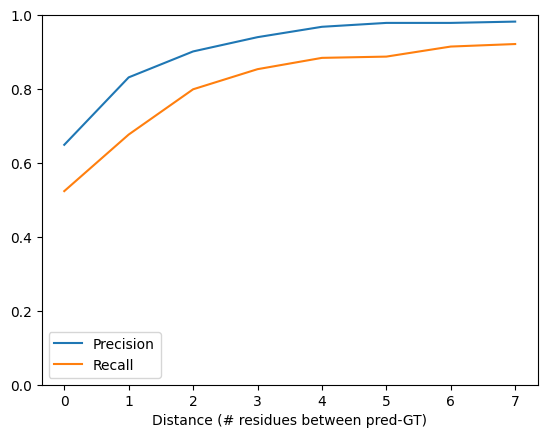

In [65]:
# Test on lysins that were not used to optimize
gt_test = gt.loc[~gt.index.isin(gt_subset.index)]
param_values = {"FREQ_LINKER": [6]}
constant_params = {"RATIO_NUM_CLUSTERS": 10, "PAE_SCORE_CUTOFF":4}
aps, apd, ags, agd, ais = optimize(param_values, constant_params, gt_test)


plt.boxplot(aps['6'], positions=[0])
plt.boxplot(ags['6'], positions=[1])
plt.boxplot(ais['6'], positions=[2])
ax = plt.gca()
ax.set_xticklabels(["Precision DBD", "Recall DBD", "IoU"])
plt.show()


for i, lab in zip([apd, agd], ["Precision", "Recall"]):
    out = np.concatenate(i['6'], axis=None).ravel()
    out = out[out != None]

    distances = [0, 1, 2, 3, 4, 5, 6, 7]
    accs = []
    for j in distances:
        accs.append((out <= j).sum() / len(out))
    plt.plot(distances, accs, label=lab)
plt.xlabel("Distance (# residues between pred-GT)")
plt.legend()
plt.ylim(0,1)
plt.show()

# Comparison to Chainsaw

### IoU scores

IoU scores for SPAED on whole dataset:


count    371.000000
mean       0.959134
std        0.082229
min        0.358024
25%        0.965945
50%        0.985396
75%        0.994158
max        1.000000
dtype: float64


IoU scores for Chainsaw on whole dataset:


count    371.000000
mean       0.937203
std        0.066429
min        0.562072
25%        0.934837
50%        0.961938
75%        0.976834
max        0.984709
dtype: float64

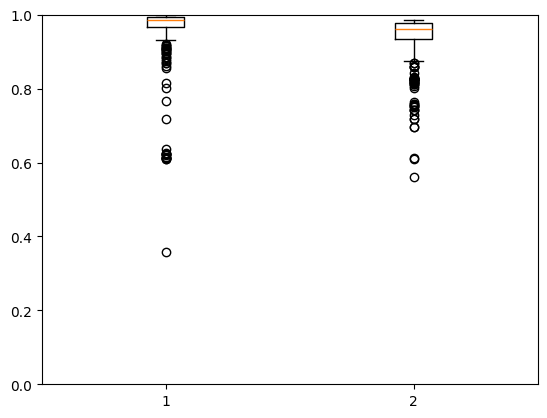

In [14]:
gt = load_gt("..\Roberto\lysins\lysins_wDomains.xlsx")
preds = load_predictions("spaed_predictions_roberto.csv")

iou_scores_spaed = []
for i in preds.index:
    if i in gt.index:
        #gt_delin = gt.loc[i].domains
        #pred_delin = preds.loc[i].domains
        iou_scores_spaed.append(calc_iou(i, gt, preds))

print("IoU scores for SPAED on whole dataset:")
display(pd.Series(iou_scores_spaed).describe())

chainsaw = load_chainsaw("chainsaw_out.txt")
iou_scores_chainsaw = []
for i in preds.index:
    if i in gt.index:
        #gt_delin = gt.loc[i].domains
        #chain_delin = chainsaw.loc[i].domains
        iou_scores_chainsaw.append(calc_iou(i, gt, chainsaw))

print("\nIoU scores for Chainsaw on whole dataset:")
display(pd.Series(iou_scores_chainsaw).describe())

plt.boxplot([iou_scores_spaed, iou_scores_chainsaw], )
plt.ylim([0, 1])
#plt.savefig("perf_iou.pdf")
plt.show()

### DBD scores

DBD scores for SPAED on whole dataset.


count    371.000000
mean       0.886950
std        0.146989
min        0.000000
25%        0.875000
50%        0.937500
75%        0.968750
max        1.000000
dtype: float64


DBD scores for Chainsaw on whole dataset.


count    371.000000
mean       0.703585
std        0.140919
min        0.000000
25%        0.617188
50%        0.750000
75%        0.812500
max        0.937500
dtype: float64

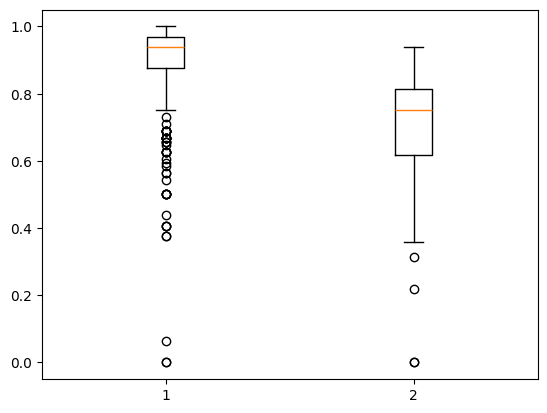

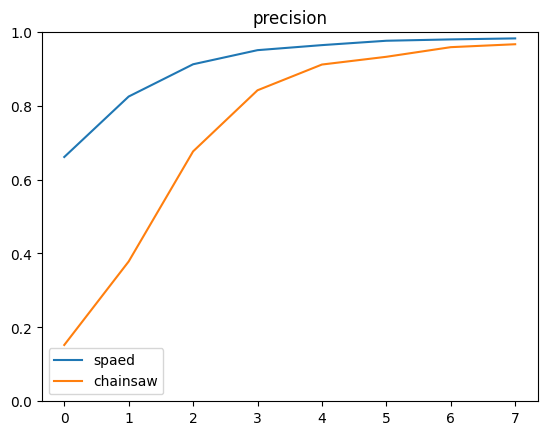

In [26]:
all_scores = []
all_distances = []
for i in gt.index:
    domScores, distances, _, _ = domBoundaryScore(i, preds, gt, preds.loc[i, "length"])
    all_scores.append(domScores)
    all_distances.append(distances)

all_chainsaw_scores = []
all_chainsaw_distances = []
for i in gt.index:
    domScores, chainsaw_distances, _, _ = domBoundaryScore(i, chainsaw, gt, chainsaw.loc[i, "nres"])
    all_chainsaw_scores.append(domScores)
    all_chainsaw_distances.append(chainsaw_distances)

print("DBD scores for SPAED on whole dataset.")
display(pd.Series(all_scores).describe())

print("\nDBD scores for Chainsaw on whole dataset.")
display(pd.Series(all_chainsaw_scores).describe())


plt.boxplot([all_scores, all_chainsaw_scores])
plt.savefig("perf_bound_prec.pdf")
plt.show()

dists = {"spaed": all_distances, "chainsaw": all_chainsaw_distances}
scores_per_distance(dists, "precision", filename="")

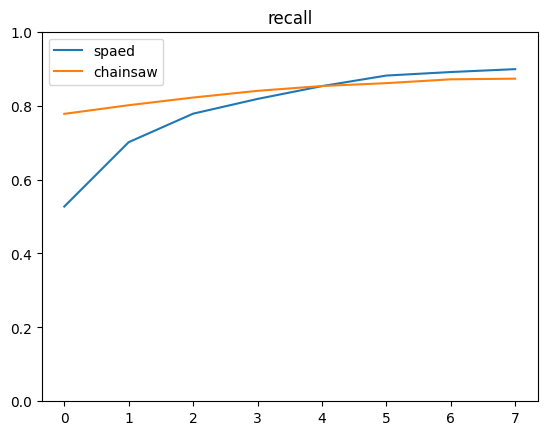

In [27]:
all_scores = []
all_distances = []
for i in gt.index:
    _, _, domScores, distances = domBoundaryScore(i, preds, gt, preds.loc[i, "length"])
    all_scores.append(domScores)
    all_distances.append(distances)

all_chainsaw_scores = []
all_chainsaw_distances = []
for i in gt.index:
    _, _, domScores, chainsaw_distances = domBoundaryScore(i, chainsaw, gt, chainsaw.loc[i, "nres"])
    all_chainsaw_scores.append(domScores)
    all_chainsaw_distances.append(chainsaw_distances)

dists = {"spaed": all_distances, "chainsaw": all_chainsaw_distances}
scores_per_distance(dists, "recall", filename="")